In [91]:
import numpy as np
import pandas as pd
data = pd.read_excel("StockDataPython.xlsx", header = None)

data = np.array(data)
data = data.squeeze()

S = 20000
T = 120
alpha = 0.5
gamma = 0.0
epsilon = 0.3
k_plus = 0.9
k_minus = 0.9

for t in range(T-1):
    data[t] = (data[t+1] - data[t])/data[t]

def choose_action(Q_plus, Q_minus, eps, curr_state):
    q_plus = np.array(Q_plus)
    q_minus = np.array(Q_minus)
    summ = (q_plus[curr_state,:] + q_minus[curr_state,:])/2
    diff = q_plus[curr_state,:]  - q_minus[curr_state, :]
    U = summ + np.random.uniform(-0.5, 0.5)*diff
    
    if np.random.uniform(0,1) < eps:
        action = np.random.randint(0,2)
    else:
        action = np.argmax(U[:])
    return action

# updates the Q-values
def update (curr_action, curr_state, Q, next_action, next_state, r,k,Q_type):
    predict = Q[curr_state, curr_action]
    target = r + gamma*Q[next_state, next_action]
    Q[curr_state, curr_action] = Q[curr_state, curr_action] + alpha*piecewise(target - predict, k, Q_type) 
    
        
# for simplicity, Q_type is a string character indicating which Q we are updating
# Q_type = 'POS' or 'NEG'
def piecewise(TD_error, k, Q_type):
    if Q_type == 'POS':
        if TD_error >= 0:
            return (1+k)*TD_error
        else:
            return (1-k)*TD_error
    elif TD_error >= 0:
        return (1-k)*TD_error
    else:
        return (1+k)*TD_error
    
# step function to take a step in the environment
# 0 means low bet and 1 means high bet as actions
def step(curr_action, curr_state, t, market_change):
    reward = (50*curr_action-25)*market_change[t]
    next_state = curr_state
    return reward, next_state


#---------------Start Training Here------------------

#-----needed for plotting purposes only--------------
plus = np.zeros((S,T,1,2))
minus = np.zeros((S,T,1,2))
Bet = np.zeros((S,T))
update_plus = np.zeros((S,T))
update_minus = np.zeros((S,T))
RPE = np.zeros((S,T))
v = np.zeros((S,T))
#----------------------------------------------------

for s in range(S):
    Q_plus = np.zeros((1,2))
    Q_minus = np.zeros((1,2))
    curr_state = 0
    curr_action = choose_action(Q_plus, Q_minus, epsilon, curr_state)
    
    for t in range(T-1):
        Bet[s,t] = 50*curr_action + 25
        counter = Bet[s,t] - 50
        
        reward, next_state = step(curr_action, curr_state, t, data)
        next_action = choose_action(Q_plus, Q_minus, epsilon, next_state)
        v[s,t] = Bet[s,t]*data[t]
        
        #--- this is not part of the SARSA but specific to the Stock Market Task
        error_plus = data[t]*counter - Q_plus[curr_state, curr_action]
        error_minus = data[t]*counter - Q_minus[curr_state,curr_action]
        update_plus[s,t] = piecewise(error_plus, k_plus, 'POS')
        update_minus[s,t] = piecewise(error_minus, k_minus, 'NEG')
        
        # SARSA update
        update(curr_action, curr_state, Q_plus, next_action, next_state, reward, k_plus, "POS")
        update(curr_action, curr_state, Q_minus, next_action, next_state, reward, k_minus, 'NEG')
        
        # update action, states
        curr_action = next_action
        curr_state  = next_state
        
        # updateing RPE - Reward Prediction Error
        if t==0:
            RPE[s,t] = v[s,t]
        elif t==1:
            RPE[s,t] = v[s,t] - RPE[s,t-1]
        else:
            temp = RPE[s,:t].squeeze()
            RPE[s,t] = (v[s,t] - np.mean(temp))/(np.std(temp))
            
    plus[s,t,:,:] = Q_plus
    minus[s,t,:,:] = Q_minus

(20000, 120)


[ 0.33589852 -0.2224941  -0.23953537  0.26096104]
(4,) (4,)


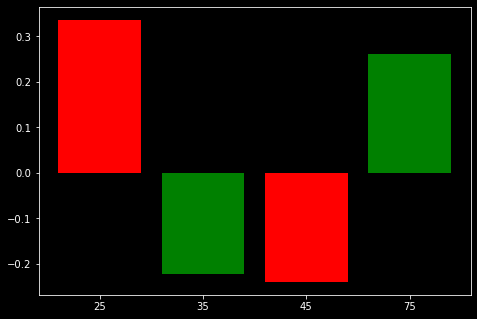

In [92]:
#------EXANPLE PLOTTING-----------------------
from matplotlib import pyplot as plt

y = np.zeros((4))
y[0] = alpha*np.mean(update_plus[ (Bet==25) & (RPE < 0)])
y[2] = alpha*np.mean(update_plus[(Bet==75) & (RPE < 0)])

y[1] = alpha*np.mean(update_plus[ (Bet==25) & (RPE > 0)])
y[3] = alpha*np.mean(update_plus[(Bet==75) & (RPE > 0)])
print(y)

print(y.shape, decks.shape)
plt.style.use(['dark_background'])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
decks = np.array(['25', '35', '45','75'])

ax.bar(decks, y, color = ['r', 'g', 'r', 'g'])
plt.show()